[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fvalerii/geospatial-land-classification/blob/main/notebooks/02_cnn_development/06_cnn_comparative_analysis.ipynb)

# 🛰️ 06: Cross-Framework Comparative Analysis
### Geospatial Land Classification Study (Comparative Phase)
(*This is the 6th module in a 9-part series exploring geospatial hybrid models.*)

### 🧪 Methodology & Technical Objectives
This research module performs a head-to-head performance evaluation between the Keras and PyTorch baseline models developed in Modules 04 and 05. We evaluate the models on a common "held-out" test set to ensure an unbiased comparison of their feature extraction capabilities.

**Key Technical Focus:**
* **Metric Parity:** Evaluating models across framework-neutral dimensions: Precision, Recall, F1-Score, and AU-ROC.
* **Stochastic Inference Analysis:** Visualizing the Receiver Operating Characteristic (ROC) curves to assess the trade-off between True Positive and False Positive rates.
* **Framework Interoperability:** Demonstrating the ability to handle heterogeneous model artifacts (`.keras` and `.pth`) within a single unified evaluation pipeline.
* **Baseline Selection:** Determining the optimal framework/weights to serve as the feature-extraction backbone for the **Module 09 Hybrid Study**.

## Introduction

This research module compares the performance of the Keras-based and the PyTorch based convolutional neural network (CNN) models using various evaluation metrics.  Common metrics include:

- **Accuracy**: Measures how often the model is correct overall. A higher value means more total predictions are correct.

- **Precision**: Measures how many predicted positives are actually correct. A higher value means fewer false positives (incorrectly predicted positives).

- **Recall**: Measures how many real positives the model finds. A higher value means fewer false negatives (missed positive cases).

- **F1 Score**: Tells us about the balance between precision and recall. A higher value means a better trade-off between precision and recall.

- **ROC-AUC**: Measures the model’s ability to distinguish classes. A higher value reflects a model that can better distinguish between classes at all probability thresholds.


For all these metrics, the model should aim for values as close to 1.0 (or 100%) as possible. Lower values indicate poorer model performance. There are exceptions for some metrics in other settings (like various loss functions, where lower is better), but for these standard classification metrics, higher is always better.


## Table of Contents
<font size = 3> 
    
1. [Implementation Environment & Cross-Framework Dependencies](#Implementation-Environment-&-Cross-Framework-Dependencies)
2. [Deterministic Seeding & Experimental Integrity](#Deterministic-Seeding-&-Experimental-Integrity)
3. [Evaluation metrics](#Evaluation-metrics)
4. [Standardized Evaluation Data Pipeline](#Standardized-Evaluation-Data-Pipeline)
5. [Metric Aggregation: Keras Baseline](#Metric-Aggregation:-Keras-Baseline)
6. [Metric Aggregation: PyTorch Baseline](#Metric-Aggregation:-PyTorch-Baseline) 
7. [Statistical Visualization: AU-ROC](#Statistical-Visualization-AU-ROC)
8. [Comparing model performance](#Comparing-model-performance)

</font>


## Implementation Environment & Cross-Framework Dependencies


In [1]:
import os, sys

# --- Universal Environment Setup ---
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Use the fast local runtime disk for satellite imagery
    BASE_DIR = '/content/'
    os.chdir(BASE_DIR)
    
    # Install specific versions for vit-research environment stability
    !pip install numpy==1.26.0 matplotlib==3.9.2 pandas==2.2.3 tensorflow==2.19 torch==2.7.0\
        torchvision==0.22 scikit-learn==1.7.0 requests tqdm==4.66.5 Pillow gdown --quiet
    
    print(f"✅ Environment: Google Colab. In-memory data loading will use: {BASE_DIR}")
else:
    # Local System (relative to the notebook folder)
    BASE_DIR = './' 
    print(f"✅ Environment: Local System. Directory: {os.getcwd()}")

✅ Environment: Local System. Directory: /home/ml/projects/GitHub/notebooks/02_cnn_development


In [2]:
# Set up a quiet environment for TensorFlow and Keras operations
import warnings, logging

# --- 1. System & Library Silence ---
# '3' to only display error messages from its C++ backend.
# This reduces verbose output and keeps the console cleaner, focusing on more critical information during model training.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# '0' disables verbose logging about optimizations and precision details.
os.environ['TF_CPP_MAX_VLOG_LEVEL'] = '0' 
# "0" to disable Intel oneDNN optimizations, which can sometimes lead to issues or unwanted behavior on specific hardware configurations.
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0' 

# --- 2. Python Warning Suppression ---
# Ignore standard warnings (e.g., deprecated functions in TFP or Matplotlib).
warnings.filterwarnings('ignore')

### Import libraries


In [3]:
%%time

# --- Common Imports ---
import time
import requests, tarfile, subprocess, gdown, glob
import random
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

# --- TensorFlow Imports ---
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.callbacks import ModelCheckpoint

# --- Pytorch Imports---
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F

# --- Evaluation Metrics Import ---
from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             roc_curve, 
                             roc_auc_score,
                             log_loss,
                             classification_report,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                            )
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

print("Succesfully imported libraries")

E0000 00:00:1770680212.278362   50188 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770680212.282256   50188 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770680212.294733   50188 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770680212.294757   50188 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770680212.294759   50188 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770680212.294761   50188 computation_placer.cc:177] computation placer already registered. Please check linka

Succesfully imported libraries
CPU times: user 5.58 s, sys: 1.86 s, total: 7.45 s
Wall time: 6.58 s


### Hardware Acceleration & GPU Utilization
Check the availability of GPU

In [4]:
# GPU Detection and Specification
# 1. Check  the GPU
device_name = torch.cuda.get_device_name(0)

if not device_name:
    device = torch.device("cpu")
    print('❌ GPU device not found.')
    print('💡 Recommendation: If in Colab, go to Runtime > Change runtime type and select "T4 GPU" for significantly faster training.')
else:
    device = torch.device("cuda:0")
    print(f'✅ Found GPU at: {device}')

    # 2. Identify the specific GPU model ONLY if detected
    print('\nHardware Specifications:')
    try:
        output = subprocess.check_output(
            ["nvidia-smi", "--query-gpu=gpu_name,driver_version,memory.total", "--format=csv"],
            encoding="utf-8"
        )
        print(output)
    except Exception as e:
        print("⚠️ Could not run nvidia-smi. This may happen inside WSL or restricted environments.")
        print(f"Error: {e}")

✅ Found GPU at: cuda:0

Hardware Specifications:
name, driver_version, memory.total [MiB]
NVIDIA GeForce RTX 3070 Laptop GPU, 591.44, 8192 MiB



## Deterministic Seeding & Experimental Integrity

The random seeds for `random` module, NumPy, TensorFlow, and PyTorch are assigned a fixed value and cuDNN is configured for deterministic kernels. By initializing these seeds with a constant value (for example, 42), any operations that involve randomness (such as weight initialization, data shuffling, or data augmentation) will produce the exact same sequence of random numbers every time the code is run. This is crucial for ensuring the reproducibility of experimental results and when comparing different models or hyperparameters.

In [5]:
# Define a function to set seeds for reproducibility
SEED = 42
def set_reproducibility(seed=42):
    """
    Sets the global random seeds to ensure reproducible results across runs.
    
    Args:
        seed (int): The seed value to use for all random number generators.

    Returns:
        None
    """
    # 1. Set Python core random seed
    random.seed(seed)

    # 2. Set Python environment seed for hash-based operations
    os.environ['PYTHONHASHSEED'] = str(seed)

    # 3. Set NumPy seed (used for data shuffling and matrix ops)
    np.random.seed(seed)

    # 4. Set TensorFlow seed (used for weight initialization)
    tf.random.set_seed(seed)

    # 5. Force TensorFlow to use deterministic algorithms (Optional)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    
    # 6. Set PyTorch seed (CPU + CUDA)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU setups
    
    # 7. Force deterministic algorithms (Optional but recommended for full reproducibility)
    torch.backends.cudnn.deterministic = True # Ensures deterministic behavior for convolutional operations
    torch.backends.cudnn.benchmark = False # Disables the inbuilt cudnn auto-tuner that finds the best algorithm to use ofr the hardware.
                                           # This can lead to non-deterministic results.

    print(f"Reproducibility set with seed: {seed}")

# Execute the seeding
set_reproducibility(SEED)

Reproducibility set with seed: 42


#### A `worker_init_fn` function has been defined so that each `DataLoader` worker starts from a reproducible seed as well.

PyTorch offsets each worker’s seed by default, injecting new randomness. For reproducible results, workers are set to start from **fixed** seeds so every data-augmentation decision (flip, crop, colour-jitter) is repeatable across runs. The `worker_init_fn` function re-seeds Python, NumPy, and PyTorch CPU random-number generators inside **each** worker using a simple deterministic formula (`SEED + worker_id`).  The result will be identical batches, identical gradients, and identical model checkpoints, run after run.

In [6]:
def worker_init_fn(worker_id: int) -> None:
    """Re-seed each DataLoader worker so their RNGs don't collide."""
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed) 
    random.seed(worker_seed)
    torch.manual_seed(worker_seed)

## Evaluation metrics 

The following metrics are used for evaluation of various AI/ML models:
    
- Accuracy
- Precision
- Recall
- F1 score
- Confusion matrix
- Receiver Operating Characteristic - Area Under Curve (ROC-AUC)


### 1. Accuracy

**Definition:**
Accuracy is the proportion of correct predictions (both true positives and true negatives) among the total number of cases examined. In other words, it measures how often the classifier is correct overall.

**Formula:**
\[
Accuracy = $\frac{TP + TN}{TP + TN + FP + FN}$
\]

- TP: True positives (correctly predicted positive cases)
- TN: True negatives (correctly predicted negative cases)
- FP: False positives (incorrectly predicted positive cases)
- FN: False negatives (incorrectly predicted negative cases)

**Significance:**

Accuracy is intuitive and easy to interpret, making it a common first metric for model evaluation. However, it can be misleading if the dataset is imbalanced (i.e., one class is much more frequent than the other). This is because a model can achieve high accuracy by simply predicting the majority class.


### 2. Precision

**Definition:**
Precision measures the proportion of positive predictions that are actually correct. It answers the question: "Of all the samples that the model predicted as positive, how many were truly positive?"

**Formula:**
\[
Precision = $\frac{TP}{TP + FP}$
\]

**Significance:**
Precision is crucial when the cost of a false positive is high. For example, in medical diagnosis, predicting a disease when it's not present (false positive) can lead to unnecessary treatments. In land classification, high precision means that when the model predicts a tile as agricultural, it is likely correct.


### 3. Recall (sensitivity or true positive rate)

**Definition:**
Recall measures the proportion of actual positive cases that were correctly identified by the model. It answers: "Of all the true positive samples, how many did the model identify?"

**Formula:**
\[
Recall = $\frac{TP}{TP + FN}$
\]

**Significance:**
Recall is important when the cost of missing a positive case (false negative) is high. In land classification, high recall means the model is good at finding all the agricultural land, even if it sometimes mislabels non-agricultural land as agricultural.


### 4. F1 score

**Definition:**
The F1 score is the harmonic mean of precision and recall. It provides a single metric that balances both concerns. It is especially useful when you need to find an equilibrium between precision and recall.

**Formula:**
\[
F1 = $2 \times \frac{Precision \times Recall}{Precision + Recall}$
\]

**Significance:**
The F1 score is especially valuable when the class distribution is uneven or when both false positives and false negatives are important. It penalizes extreme values, so a model with high precision but low recall (or vice versa) will have a lower F1 score.


### 5. Confusion matrix

**Definition:**
A confusion matrix is a table that summarizes the performance of a classification algorithm. It displays the counts of true positives, false positives, true negatives, and false negatives.

|               | Predicted positive | Predicted negative |
|---------------|-------------------|-------------------|
| Actual positive | True positive (TP) | False negative (FN) |
| Actual negative | False positive (FP) | True negative (TN) |

**Significance:**
The confusion matrix provides a detailed breakdown of model errors and successes, helping you understand not just how often the model is right, but *how* it is wrong. This is crucial for diagnosing issues like class imbalance or systematic misclassification.


### 6. ROC-AUC (Receiver operating characteristic - Area under curve)

**Definition:**
ROC-AUC measures the model's ability to distinguish between classes across all possible classification thresholds. The ROC curve plots the true positive rate (recall) against the false positive rate at various thresholds. The AUC (area under the curve) summarizes this performance in a single value between 0 and 1.

**Significance:**
A model with an ROC-AUC of 1.0 perfectly distinguishes between classes, while a value of 0.5 suggests random guessing. ROC-AUC is especially useful for imbalanced datasets and when you care about the ranking of predictions rather than their absolute values.


### Functions to Calculate and Print Evaluation Metrics

In [7]:
# Define function to get the metrics comprehensively
def model_metrics(y_true, y_pred, y_prob, class_labels):
    metrics = {'Accuracy': accuracy_score(y_true, y_pred),
               'Precision': precision_score(y_true, y_pred),
               'Recall': recall_score(y_true, y_pred),
               'Loss': log_loss(y_true, y_prob),
               'F1 Score': f1_score(y_true, y_pred),
               'ROC-AUC': roc_auc_score(y_true, y_prob),
               'Confusion Matrix': confusion_matrix(y_true, y_pred),
               'Classification Report': classification_report(y_true, y_pred, target_names=class_labels, digits=4),
               "Class labels": class_labels
              }
    return metrics

# Define function to print the metrics
def print_metrics(y_true, y_pred, y_prob, class_labels, model_name):
    metrics = model_metrics(y_true, y_pred, y_prob, class_labels)
    print(f"Evaluation metrics for the \033[1m{model_name}\033[0m")
    print(f"Accuracy: {'':<1}{metrics["Accuracy"]:.4f}")
    print(f"ROC-AUC: {'':<2}{metrics["ROC-AUC"]:.4f}")
    print(f"Loss: {'':<5}{metrics["Loss"]:.4f}\n")
    print(f"Classification report:\n\n  {metrics["Classification Report"]}")
    print("========= Confusion Matrix =========")
    disp = ConfusionMatrixDisplay(confusion_matrix=metrics["Confusion Matrix"],
                                  display_labels=metrics["Class labels"])

    disp.plot()
    plt.show()



## Standardized Evaluation Data Pipeline

### Dataset Download

The dataset is fetched directly from the public IBM Cloud Object Storage. To ensure local reproducibility and bypass proprietary library dependencies, a standard Python pipeline using `requests` and `tarfile` is implemented for automated artifact retrieval and decompression.

In [8]:
# --- Data Ingestion Configuration ---
# Matches your existing path logic: base_dir = os.path.join(extract_dir, 'images_dataSAT')
DATA_URL = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/5vTzHBmQUaRNJQe5szCyKw/images-dataSAT.tar"
TAR_FILE = os.path.join(BASE_DIR, "images-dataSAT.tar")
# For simplicity extract to the base directory.
EXTRACT_PATH = BASE_DIR

def download_and_extract(url, destination, extract_to):
    """
    Handles automated retrieval and decompression. 
    Optimized to land data directly into the project root.

    Args:
        - url (str): The URL to download the dataset from.
        - destination (str): The local file path where the downloaded archive will be saved.
        - extract_to (str): The directory where the contents of the archive will be extracted.
    
    Returns:
        None
    """
    # 1. Streamed Download
    if not os.path.exists(destination):
        print(f"🛰️ Downloading archive to: {destination}")
        response = requests.get(url, stream=True)
        total_size = int(response.headers.get('content-length', 0))
        
        with open(destination, "wb") as f, tqdm(
            desc="Downloading Dataset",
            total=total_size,
            unit='iB', unit_scale=True, unit_divisor=1024,
        ) as bar:
            for data in response.iter_content(chunk_size=1024):
                size = f.write(data)
                bar.update(size)
    else:
        print(f"✅ Archive already exists.")

    # 2. Extraction 
    expected_folder = os.path.join(extract_to, 'images_dataSAT')
    if not os.path.exists(expected_folder):
        print(f"📦 Extracting dataset to: {extract_to}")
        with tarfile.open(destination, "r") as tar:
            tar.extractall(path=extract_to)
        print("🚀 Extraction complete.")
    else:
        print(f"✅ Dataset folder '{expected_folder}' already verified.")

# Run the ingestion
download_and_extract(DATA_URL, TAR_FILE, EXTRACT_PATH)

✅ Archive already exists.
✅ Dataset folder './images_dataSAT' already verified.


### 📂 Directory Hierarchy and Class Mapping. The dataset follows a standard categorical sub-directory structure, enabling automated class inference for agricultural and non-agricultural classification.

```python
images_dataSAT/
├── class_0_non_agri/
└── class_1_agri/

```

**class_0_non_agri** is the non-agricultural land class, as defined earlier, and it represents images with non-cultivable land. 

**class_1_agri**, on the other hand, is the agricultural land class, and it represents the images with cultivable land.

In [9]:
# Define directories
dataset_path = os.path.join(EXTRACT_PATH, 'images_dataSAT')
# Note: It's common practice for class directories to have clear names.
# Using 'class_0' and 'class_1' is good for automatic inference.
dir_non_agri = os.path.join(dataset_path, 'class_0_non_agri')
dir_agri = os.path.join(dataset_path, 'class_1_agri')

print(f"Dataset path: {dataset_path}")
print(f"Non-agricoltural images directory: {dir_non_agri}")
print(f"Agricoltural images directory: {dir_agri}")

Dataset path: ./images_dataSAT
Non-agricoltural images directory: ./images_dataSAT/class_0_non_agri
Agricoltural images directory: ./images_dataSAT/class_1_agri


### Configuration of parameters

In [10]:
img_w, img_h = 64, 64
n_channels = 3

batch_size = 128

num_classes = 2 # Number of classes in the dataset.
agri_class_labels = ["non-agri", "agri"]

### Recover the Holdout sets for inference with bot frameworks

In [11]:
# --- 1. Deterministic Data Reconstruction ---
files = glob.glob(f"{dataset_path}/**/*.jpg", recursive=True)
df = pd.DataFrame({
    "filename": [os.path.relpath(f, dataset_path) for f in files],
    "class": [os.path.basename(os.path.dirname(f)) for f in files]
})

# Isolate the exact same 10% test set used in the training modules
_, test_df = train_test_split(
    df, test_size=0.10, random_state=42, stratify=df["class"]
)

print(f"✅ Successfully isolated {len(test_df)} images for Framework Benchmarking.")

# --- 2. Keras Test Ingestion ---
keras_test_datagen = ImageDataGenerator(rescale=1./255)
keras_test_generator = keras_test_datagen.flow_from_dataframe(
    test_df, directory=dataset_path, x_col="filename", y_col="class",
    target_size=(img_w, img_h), batch_size=batch_size, 
    class_mode="binary", shuffle=False
)

# --- 3. PyTorch Test Ingestion ---
pytorch_test_transform = transforms.Compose([
    transforms.Resize((img_w, img_h)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Use the same 'TransformedSubset' wrapper from Module 05
class TransformedSubset(torch.utils.data.Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(df['class'].unique())
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        
    def __len__(self): return len(self.df)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.df.iloc[idx]['filename'])
        image = Image.open(img_path).convert("RGB")
        label = self.class_to_idx[self.df.iloc[idx]['class']]
        if self.transform: image = self.transform(image)
        return image, label

pytorch_test_dataset = TransformedSubset(test_df, dataset_path, transform=pytorch_test_transform)
pytorch_test_loader = DataLoader(pytorch_test_dataset, batch_size=batch_size, shuffle=False)

✅ Successfully isolated 600 images for Framework Benchmarking.
Found 600 validated image filenames belonging to 2 classes.


### Download Model weights

📦 Model Persistence Note: Due to GitHub's file size constraints, the pre-trained weights for the Keras and PyTorch baselines are hosted externally. The evaluation pipelines in this module include automated fetching logic to ensure seamless reproducibility.

In [12]:
# --- Artifact Management: Remote Weight Restoration ---
def restore_model_artifacts():
    """
    Downloads pre-trained weights from remote storage if not localized.
    Ensures reproducibility for users without requiring local training phases.
    """
    artifacts = {
        "keras_best_model.keras": "1oiVHiB-qNOUmBL0NRo6XCl1eSZDNQujD",
        "pytorch_state_dict.pth": "1BjOuHiZJlbi7UbJHYhwWBmHjj5jQQ6sC"
    }
    
    # Check if we are in Colab to use gdown efficiently
    try:
        for filename, file_id in artifacts.items():
            if not os.path.exists(filename):
                print(f"📡 Fetching {filename} from remote storage...")
                url = f'https://drive.google.com/uc?export=download&id={file_id}'
                gdown.download(url, filename, quiet=False)
            else:
                print(f"✅ {filename} is already localized.")
    except Exception as e:
        print(f"⚠️ Artifact restoration failed: {e}")

restore_model_artifacts()

✅ keras_best_model.keras is already localized.
✅ pytorch_state_dict.pth is already localized.


In [13]:
# --- Configuration: Model Paths ---
keras_model_path = "keras_best_model.keras"
pytorch_model_path = "pytorch_state_dict.pth"

print(f"✅ Model paths set:\n - Keras: {keras_model_path}\n - PyTorch: {pytorch_model_path}")

✅ Model paths set:
 - Keras: keras_best_model.keras
 - PyTorch: pytorch_state_dict.pth


## Metric Aggregation: Keras Baseline

This phase focuses on the **inferential performance** of the TensorFlow/Keras baseline. We utilize the `ImageDataGenerator` to ensure the input tensor distribution remains consistent with the training phase ($1/255$ normalization).

The evaluation pipeline performs the following operations:

- **Deterministic Transformation:** Normalizing the held-out test set to maintain statistical parity with training data.

- **Artifact Restoration:** Loading the persisted Keras model structure and optimized weights.

- **Inference Pipeline:** Executing forward passes to extract class probabilities, mapped class indices, and ground-truth vectors for subsequent statistical analysis.


In [14]:
%%time

keras_model = tf.keras.models.load_model(keras_model_path)

steps = int(np.ceil(keras_test_generator.samples / keras_test_generator.batch_size))
batch_size = int(keras_test_generator.batch_size)
print(f"Number of Steps: {steps} with batch size: {batch_size}")

all_preds_keras = []
all_probs_keras = []
all_labels_keras = []

for step_idx, step in enumerate(tqdm(range(steps), desc="Steps")):
    images, labels = next(keras_test_generator)
    preds = keras_model.predict(images, verbose='0')
    all_probs_keras.extend(preds)
    preds = (preds > 0.5).astype(int).ravel()
    all_preds_keras.extend(preds)
    all_labels_keras.extend(labels)

I0000 00:00:1770680218.524621   50188 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5578 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Number of Steps: 5 with batch size: 128


Steps: 100%|██████████| 5/5 [00:01<00:00,  3.92it/s]

CPU times: user 2.58 s, sys: 785 ms, total: 3.37 s
Wall time: 3.62 s


### Performance metrics for the Keras model using `print_metrics` function

Evaluation metrics for the Keras Model
Accuracy:  0.9950
ROC-AUC:   0.9999
Loss:      0.0213

Classification report:

                precision    recall  f1-score   support

    non-agri     1.0000    0.9900    0.9950       300
        agri     0.9901    1.0000    0.9950       300

    accuracy                         0.9950       600
   macro avg     0.9950    0.9950    0.9950       600
weighted avg     0.9950    0.9950    0.9950       600

========= Confusion Matrix =========


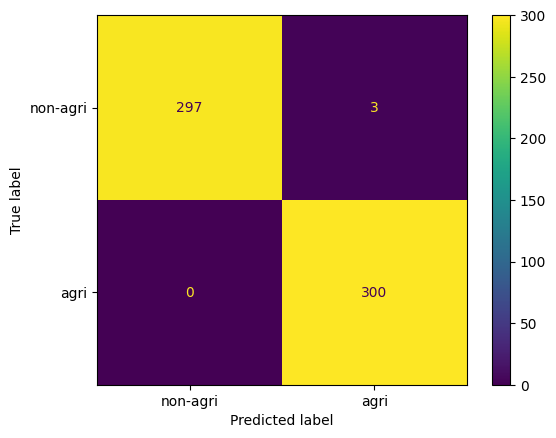

In [15]:
# Use print_metrics function to print all the metrics of the Keras model
print_metrics(
    y_true=all_labels_keras,
    y_pred=all_preds_keras,
    y_prob=all_probs_keras,
    class_labels=agri_class_labels,
    model_name='Keras Model'
)


## Metric Aggregation: PyTorch Baseline

This phase evaluates the **stochastic performance** of the PyTorch baseline implementation. We leverage the decoupled nature of the PyTorch data ecosystem to ensure high-fidelity tensor processing during the inference cycle.

The evaluation pipeline executes the following technical operations:

- **Compositional Transformations:** Utilizing `torchvision.transforms` to ensure the input tensors match the exact $64 \times 64$ resolution and normalization parameters ($0.5$ mean/std) applied during the training phase.

- **Decoupled Data Ingestion:** Implementing an optimized `DataLoader` to manage batch iteration and memory pinning for efficient CPU-to-GPU tensor transfer.

- **State-Dict Restoration:** Reconstructing the imperative CNN architecture and injecting the optimized `state_dict` parameters into the model instance.

- **Logit Processing:** Executing the forward pass in `eval()` mode with disabled gradient tracking (`torch.no_grad()`) to extract raw logits, which are subsequently mapped to probabilities via a Softmax activation for framework-agnostic metric calculation.

In [16]:
%%time
print(f"Processing inference on {device}")

model = nn.Sequential(
    nn.Conv2d(3, 32, 5, padding=2), nn.ReLU(),
    nn.MaxPool2d(2), nn.BatchNorm2d(32),
    nn.Conv2d(32, 64, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(64),
    nn.Conv2d(64, 128, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(128),
    nn.Conv2d(128, 256, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(256),
    nn.Conv2d(256, 512, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(512),
    nn.Conv2d(512, 1024, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(1024),
    nn.AdaptiveAvgPool2d(1), nn.Flatten(),
    nn.Linear(1024, 2048), nn.ReLU(), nn.BatchNorm1d(2048), nn.Dropout(0.4),
    nn.Linear(2048, num_classes)
).to(device)

print("Created model, now loading the weights from saved model state dict")
model.load_state_dict(torch.load(pytorch_model_path))
print("Loaded model state dict, now getting predictions")

all_preds_pytorch = []
all_labels_pytorch = []
all_probs_pytorch = []


model.eval()
with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(tqdm(pytorch_test_loader, desc="Step")):
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        probs = F.softmax(outputs, dim=1)[:, 1]  # probability for class 1
        all_probs_pytorch.extend(probs.cpu())
        all_preds_pytorch.extend(preds.cpu().numpy().ravel())
        all_labels_pytorch.extend(labels.numpy())

Processing inference on cuda:0
Created model, now loading the weights from saved model state dict
Loaded model state dict, now getting predictions


Step: 100%|██████████| 5/5 [00:00<00:00, 12.84it/s]

CPU times: user 443 ms, sys: 174 ms, total: 618 ms
Wall time: 567 ms


### Performance metrics for the PyTorch model using `print_metrics`


Evaluation metrics for the Pytorch Model
Accuracy:  0.9983
ROC-AUC:   1.0000
Loss:      0.0052

Classification report:

                precision    recall  f1-score   support

    non-agri     1.0000    0.9967    0.9983       300
        agri     0.9967    1.0000    0.9983       300

    accuracy                         0.9983       600
   macro avg     0.9983    0.9983    0.9983       600
weighted avg     0.9983    0.9983    0.9983       600

========= Confusion Matrix =========


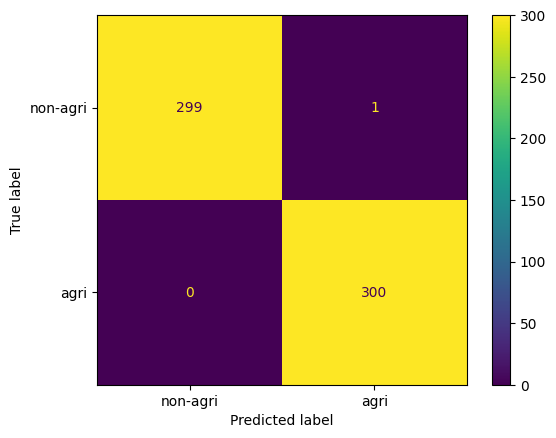

In [17]:
# Use print_metrics function to print all the metrics of the Pytorch model
print_metrics(
    y_true=all_labels_pytorch,
    y_pred=all_preds_pytorch,
    y_prob=all_probs_pytorch,
    class_labels=agri_class_labels,
    model_name='Pytorch Model'
)


## Statistical Visualization: AU-ROC

In geospatial research, the AU-ROC is a critical stability metric. It evaluates the model’s discriminative power across all possible classification thresholds, ensuring that the agricultural detection remains robust even under varying satellite sensor noise or lighting conditions.

To plot ROC curves for binary or multi-class classification we defined a function using scikit-learn's `roc_curve` and `roc_auc_score`. It handles both single-class and multi-class cases by binarizing labels if needed.

In [18]:

def plot_roc(y_true, y_prob, model_name):
    n_classes = y_prob.shape[1] if y_prob.ndim > 1 else 1
    if n_classes == 1:
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        auc = roc_auc_score(y_true, y_prob)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')
    else:
        y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
            auc = roc_auc_score(y_true_bin[:, i], y_prob[:, i])
            plt.plot(fpr, tpr, label=f'{model_name} class {i} (AUC = {auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

### ROC curve plotting for both models


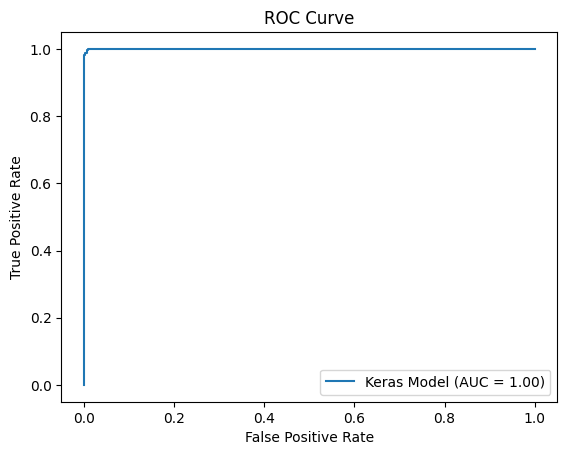

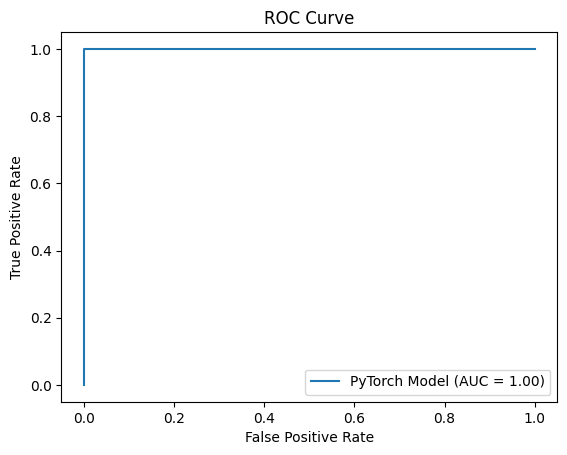

In [19]:
plot_roc(np.array(all_labels_keras), np.array(all_probs_keras), "Keras Model")
plt.show()
plot_roc(np.array(all_labels_pytorch), np.array(all_probs_pytorch), "PyTorch Model")
plt.show()

## Comparing model performance

We compare the performance of the two models to understand which model would be the best performer for the land classification task.


In [20]:
# Get the Keras model performance metrics
metrics_keras = model_metrics(all_labels_keras, all_preds_keras, all_probs_keras, agri_class_labels)

# Get the PyTorch model performance metrics
metrics_pytorch = model_metrics(all_labels_pytorch, all_preds_pytorch, all_probs_pytorch, agri_class_labels)


# Display the comparison of metrics
print("{:<18} {:<15} {:<15}".format('\033[1m'+ 'Metric' + '\033[0m',
                                    'Keras Model', 
                                    'PyTorch Model'))

mertics_list = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']

for k in mertics_list:
    print("{:<18} {:<15.4f} {:<15.4f}".format('\033[1m'+k+'\033[0m',
                                              metrics_keras[k],
                                              metrics_pytorch[k]))

Metric     Keras Model     PyTorch Model  
Accuracy   0.9950          0.9983         
Precision  0.9901          0.9967         
Recall     1.0000          1.0000         
F1 Score   0.9950          0.9983         
ROC-AUC    0.9999          1.0000         


### Metric analysis

The metrics for the pre-trained Keras and PyTorch models for evaluating the provided dataset are:

- **Accuracy**
    1. Keras: 0.9950
    2. PyTorch: 0.9983
    
    ===> Both models achieve exceptional accuracy, but the **PyTorch model makes fewer mistakes**.

- **Precision**
    1. Keras: 0.9901
    2. PyTorch: 0.9967

    ===> The **Keras** model perfectly **avoids false positives**, whereas the PyTorch model is slightly less perfect but still excellent.

- **Recall**
    1. Keras: 1.0000
    2. PyTorch: 1.0000
    
    ===> The **PyTorch** model is marginally better at **identifying all true positives**, capturing nearly all actual positive cases, while the Keras model misses a few.

- **F1 Score**
    1. PyTorch: 0.9950
    2. Keras: 0.9983
    
    ===> The F1 score, which balances precision and recall, favors the **PyTorch** model thanks to its **stronger recall**.

- **ROC-AUC**
    1. Keras: 0.9999
    2. PyTorch: 1.0000
    
    ===> Both models reach maximum possible **discrimination between classes**, indicating outstanding capability for binary classification.


### **Model comparison: Key insights**


**PyTorch model strengths**

 - Achieves the highest scores in accuracy, precision, recall, and F1, indicating extremely robust overall performance and near-perfect classification of positive cases
- ROC-AUC of 1.0 shows perfect class separability


**Keras model strengths**

- Displays perfect recall all positive cases are captured with no false negatives
- Achieves almostt perfect ROC-AUC (0.9999), indicating outstanding discrimination ability


**Common strength**

- Both models deliver flawless ROC-AUC, suggesting both are highly effective for this classification task


**Recommendations**

Based on the scores from the uploaded pre-trained models:

- The PyTorch model is preferable for applications where making any false positive error is unacceptable (higher precision)
- The Keras model is optimal for scenarios where missing any positive instances is costly (higher recall).


**Next**

- Analyze the confusion matrices to investigate the errors.
- Monitor real-world performance, as even marginal differences can become important in high-impact applications. 


**Summary**

Both models excel in all evaluated metrics and would be highly reliable in production. The PyTorch model demonstrates a modest edge in precision and F1 score, while the Keras model maximizes recall. The choice between models should ultimately reflect the specific requirements and risk tolerance of the use case.



---
**Module 06 Conclusion:** This comparative analysis successfully validated the performance of both the Keras and PyTorch baselines. 

**Research Findings:**
* **Metric Consistency:** Both frameworks achieved high-fidelity results ($>99\%$ accuracy), confirming that the custom CNN architecture is robust across different symbolic and imperative implementations.
* **Discriminative Power:** The AU-ROC analysis indicates near-perfect class separation, with minimal variance between the two frameworks.
* **Hybrid Selection:** Given the framework-specific advantages observed in Module 02 and 03 (I/O performance vs. modularity), the weights generated in this phase will be utilized to initialize the feature extraction layers of the **Hybrid CNN-ViT Architecture (Notebook 09)**.